In [1]:
# Imports 

import numpy as np
from numpy import *
import scipy
from scipy.special import erf

In [5]:
N_atoms = 2
atoms = ['He','H']


In [6]:
atoms

['He', 'H']

In [7]:
# Basis set variables

# STO-nG (number of gaussians used to form a contracted gaussian orbital - pp153)
STOnG = 3

# Dictionary of zeta values (pp159-160, 170)
zeta_dict = {'H': [1.24], 'He':[2.0925], 'Li':[2.69,0.80],'Be':[3.68,1.15],
            'B':[4.68,1.50],'C':[5.67,1.72]}   #Put zeta number in list to accomodate for possibly more basis sets (eg 2s orbital)

# Dictionary containing the max quantum number of each atom, 
# for a minimal basis STO-nG calculation
max_quantum_number = {'H':1,'He':1,'Li':2,'Be':2,'C':2}


# Gaussian contraction coefficients (pp157)
# Going up to 2s orbital (W. J. Hehre, R. F. Stewart, and J. A. Pople. J. Chem. Phys. 51, 2657 (1969))
# Row represents 1s, 2s etc...
D = np.array([[0.444635, 0.535328, 0.154329],
              [0.700115,0.399513,-0.0999672]])

# Gaussian orbital exponents (pp153)
# Going up to 2s orbital (W. J. Hehre, R. F. Stewart, and J. A. Pople. J. Chem. Phys. 51, 2657 (1969))
alpha = np.array([[0.109818, 0.405771, 2.22766],
                     [0.0751386,0.231031,0.994203]])

# Basis set size
B = 0
for atom in atoms:
    B += max_quantum_number[atom]

In [8]:
# Other book-keeping

# Number of electrons (Important!!)
N = 2

# Keep a dictionary of charges
charge_dict = {'H': 1, 'He': 2, 'Li':3, 'Be':4,'B':5,'C':6,'N':7,'O':8,'F':9,'Ne':10}

In [9]:
# Integrals between Gaussian orbitals (pp410)

def gauss_product(gauss_A, gauss_B):
    # The product of two Gaussians gives another Gaussian (pp411)
    # Pass in the exponent and centre as a tuple
    
    a, Ra = gauss_A
    b, Rb = gauss_B
    p = a + b
    diff = np.linalg.norm(Ra-Rb)**2             # squared difference of the two centres
    N = (4*a*b/(pi**2))**0.75                   # Normalisation
    K = N*exp(-a*b/p*diff)                      # New prefactor
    Rp = (a*Ra + b*Rb)/p                        # New centre
                     
    return p, diff, K, Rp

# Overlap integral (pp411)
def overlap(A, B):
    p, diff, K, Rp = gauss_product(A, B)
    prefactor = (pi/p)**1.5
    return prefactor*K

# Kinetic integral (pp412)
def kinetic(A,B):
    p, diff, K, Rp = gauss_product(A, B)
    prefactor = (pi/p)**1.5
    
    a, Ra = A
    b, Rb = B    
    reduced_exponent = a*b/p
    return reduced_exponent*(3-2*reduced_exponent*diff)*prefactor*K


# Fo function for calculating potential and e-e repulsion integrals.
# Just a variant of the error function
# pp414
def Fo(t):
    if t == 0:
        return 1
    else:
        return (0.5*(pi/t)**0.5)*erf(t**0.5)


# Nuclear-electron integral (pp412)
def potential(A,B,atom_idx):
    p,diff,K,Rp = gauss_product(A,B)
    Rc = atom_coordinates[atom_idx] # Position of atom C
    Zc = charge_dict[atoms[atom_idx]] # Charge of atom C
    
    
    return (-2*pi*Zc/p)*K*Fo(p*np.linalg.norm(Rp-Rc)**2)

# (ab|cd) integral (pp413)
def multi(A,B,C,D):
    p, diff_ab, K_ab, Rp = gauss_product(A,B)
    q, diff_cd, K_cd, Rq = gauss_product(C,D)
    multi_prefactor = 2*pi**2.5*(p*q*(p+q)**0.5)**-1
    return multi_prefactor*K_ab*K_cd*Fo(p*q/(p+q)*np.linalg.norm(Rp-Rq)**2)

In [28]:
#listofenergies = []
#for coordchanger in [coordman * 0.01 for coordman in range(5, 200)]:
atom_coordinates = [np.array((0.0,0.0,0.0)),np.array((0.0,0.0, 1.4632))]
# Initialise matrices
S = np.zeros((B,B))
T = np.zeros((B,B))
V = np.zeros((B,B))
multi_electron_tensor = np.zeros((B,B,B,B))


# Iterate through atoms
for idx_a, val_a in enumerate(atoms):

    # For each atom, get the charge and centre
    Za = charge_dict[val_a]
    Ra = atom_coordinates[idx_a]

    # Iterate through quantum numbers (1s, 2s etc)
    for m in range(max_quantum_number[val_a]):

        # For each quantum number, get the contraction
        # coefficients, then get zeta,
        # then scale the exponents accordingly (pp158)
        d_vec_m = D[m]
        zeta = zeta_dict[val_a][m]
        alpha_vec_m = alpha[m]*zeta**2
        print('alpha_vec_m:'+ str(alpha_vec_m))
        # Iterate over the contraction coefficients
        for p in range(STOnG):


            # Iterate through atoms once again (more info in blog post)
            for idx_b, val_b in enumerate(atoms):
                Zb = charge_dict[val_b]
                Rb = atom_coordinates[idx_b]
                for n in range(max_quantum_number[val_b]):
                    d_vec_n = D[n]
                    zeta = zeta_dict[val_b][n]
                    alpha_vec_n = alpha[n]*zeta**2
                    print('alpha_vec_n:' + str(alpha_vec_n))
                    for q in range(STOnG):


                        # This indexing is explained in the blog post.
                        # In short, it is due to Python indexing
                        # starting at 0.

                        a = (idx_a+1)*(m+1)-1
                        b = (idx_b+1)*(n+1)-1

                        # Generate the overlap, kinetic and potential matrices

                        S[a,b] += d_vec_m[p]*d_vec_n[q]*overlap((alpha_vec_m[p],Ra),(alpha_vec_n[q],Rb))
                        T[a,b] += d_vec_m[p]*d_vec_n[q]*kinetic((alpha_vec_m[p],Ra),(alpha_vec_n[q],Rb))

                        for i in range(N_atoms):
                            V[a,b] += d_vec_m[p]*d_vec_n[q]*potential((alpha_vec_m[p],Ra),(alpha_vec_n[q],Rb),i)


                        # 2 more iterations to get the multi-electron-tensor
                        for idx_c, val_c in enumerate(atoms):
                            Zc = charge_dict[val_c]
                            Rc = atom_coordinates[idx_c]
                            for k in range(max_quantum_number[val_c]):
                                d_vec_k = D[k]
                                zeta = zeta_dict[val_c][k]
                                alpha_vec_k = alpha[k]*zeta**2
                                for r in range(STOnG):
                                    for idx_d, val_d in enumerate(atoms):
                                        Zd = charge_dict[val_d]
                                        Rd = atom_coordinates[idx_d]
                                        for l in range(max_quantum_number[val_d]):
                                            d_vec_l = D[l]
                                            zeta = zeta_dict[val_d][l]
                                            alpha_vec_l = alpha[l]*zeta**2
                                            for s in range(STOnG):
                                                c = (idx_c+1)*(k+1)-1
                                                d = (idx_d+1)*(l+1)-1
                                                multi_electron_tensor[a,b,c,d] += d_vec_m[p]*d_vec_n[q]*d_vec_k[r]*d_vec_l[s]*(
                                                multi((alpha_vec_m[p],Ra),
                                                      (alpha_vec_n[q],Rb),
                                                      (alpha_vec_k[r],Rc),
                                                      (alpha_vec_l[s],Rd))
                                                )






# Form Hcore
Hcore = T + V

# Symmetric Orthogonalisation of basis (p144)

evalS, U = np.linalg.eig(S)
diagS = dot(U.T,dot(S,U))
diagS_minushalf = diag(diagonal(diagS)**-0.5)
X = dot(U,dot(diagS_minushalf,U.T))

def SD_successive_density_matrix_elements(Ptilde,P):
    x = 0
    for i in range(B):
        for j in range(B):
            x += B**-2*(Ptilde[i,j]-P[i,j])**2

    return x**0.5

# Algorithm

# Initial guess at P
P = np.zeros((B,B))
P_previous = np.zeros((B,B))
P_list = []

# Iterative process
threshold = 100
while threshold > 10**-4:

    # Calculate Fock matrix with guess
    G = np.zeros((B,B))
    for i in range(B):
        for j in range(B):
            for x in range(B):
                for y in range(B):
                    G[i,j] += P[x,y]*(multi_electron_tensor[i,j,y,x]-0.5*multi_electron_tensor[i,x,y,j])    
    Fock = Hcore + G

    # Calculate Fock matrix in orthogonalised base
    Fockprime = dot(X.T,dot(Fock, X))
    evalFockprime, Cprime = np.linalg.eig(Fockprime)

    #Correct ordering of eigenvalues and eigenvectors (starting from ground MO as first column of C, else we get the wrong P)
    idx = evalFockprime.argsort()
    evalFockprime = evalFockprime[idx]
    Cprime = Cprime[:,idx]

    C = dot(X,Cprime) 

    # Form new P (note, we only sum over electron pairs - we DON'T sum
    # over the entire basis set. 

    for i in range(B):
        for j in range(B):
            for a in range(int(N/2)):
                P[i,j] = 2*C[i,a]*C[j,a]


    P_list.append(P)

    threshold = SD_successive_density_matrix_elements(P_previous,P)
    P_previous = P.copy()

listofenergies.append((evalFockprime[0] + get_nuclear_repulsion()))

alpha_vec_m:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]
alpha_vec_m:[0.16885616 0.62391349 3.42525002]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]
alpha_vec_n:[0.48084429 1.77669115 9.75393462]
alpha_vec_n:[0.16885616 0.62391349 3.42525002]


In [25]:
print(T)

[[2.16431256 0.16701287]
 [0.16701287 0.76003294]]


In [14]:
# Nuclear repulsion
def get_nuclear_repulsion():
    Nuc_repuls = 0
    for idx_a, A in enumerate(atoms):
        for idx_b, B in enumerate(atoms):
            if idx_a == idx_b:
                continue
            charge_A = charge_dict[A]
            charge_B = charge_dict[B]
            product = charge_A*charge_B
            Ra = atom_coordinates[idx_a]
            Rb = atom_coordinates[idx_b]
            R = np.linalg.norm(Ra-Rb)
            Nuc_repuls += product/R
    return Nuc_repuls*0.5

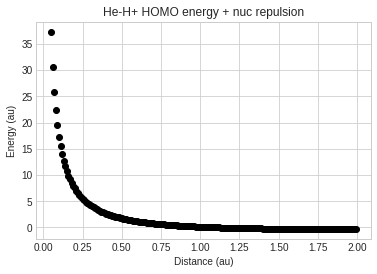

In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

evalFockprime[0]

x = [coordman * 0.01 for coordman in range(5, 200)]
y = listofenergies 

plt.title('He-H+ HOMO energy + nuc repulsion')
plt.xlabel('Distance (au)')
plt.ylabel('Energy (au)')

plt.plot(x,y,'o',color='black')

In [21]:
evalFockprime[0]


-1.5974477442856965

In [22]:
get_nuclear_repulsion()

1.366867140513942